## Data exploration and Preprocessing

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [14]:
df = pd.read_csv(r'C:\Users\redmi\Downloads\Problem-A-20260213T090732Z-1-001\Problem-A\dataset\heart_cleveland_upload.csv')

In [15]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [16]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [9]:
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

#### Insight 1 : Dataset have no missing values

In [22]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.120795,0.227075
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.370556,0.278467
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.266275,0.408945
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.130612,0.153490
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.023441,0.080285
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.051038,0.003167
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.013612,0.166343
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.258386,-0.423817
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.323268,0.421355
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.336809,0.424052


<Axes: >

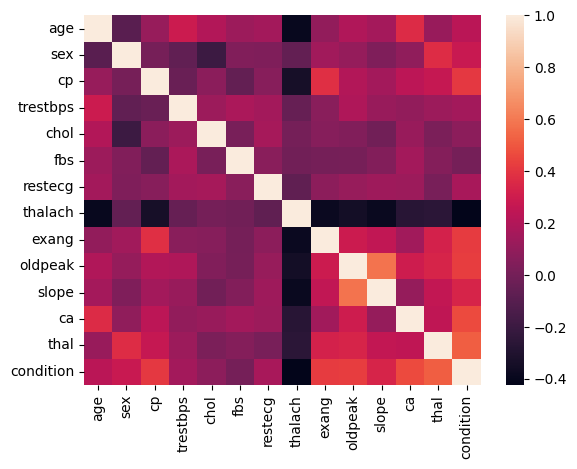

In [21]:
sns.heatmap(df.corr())

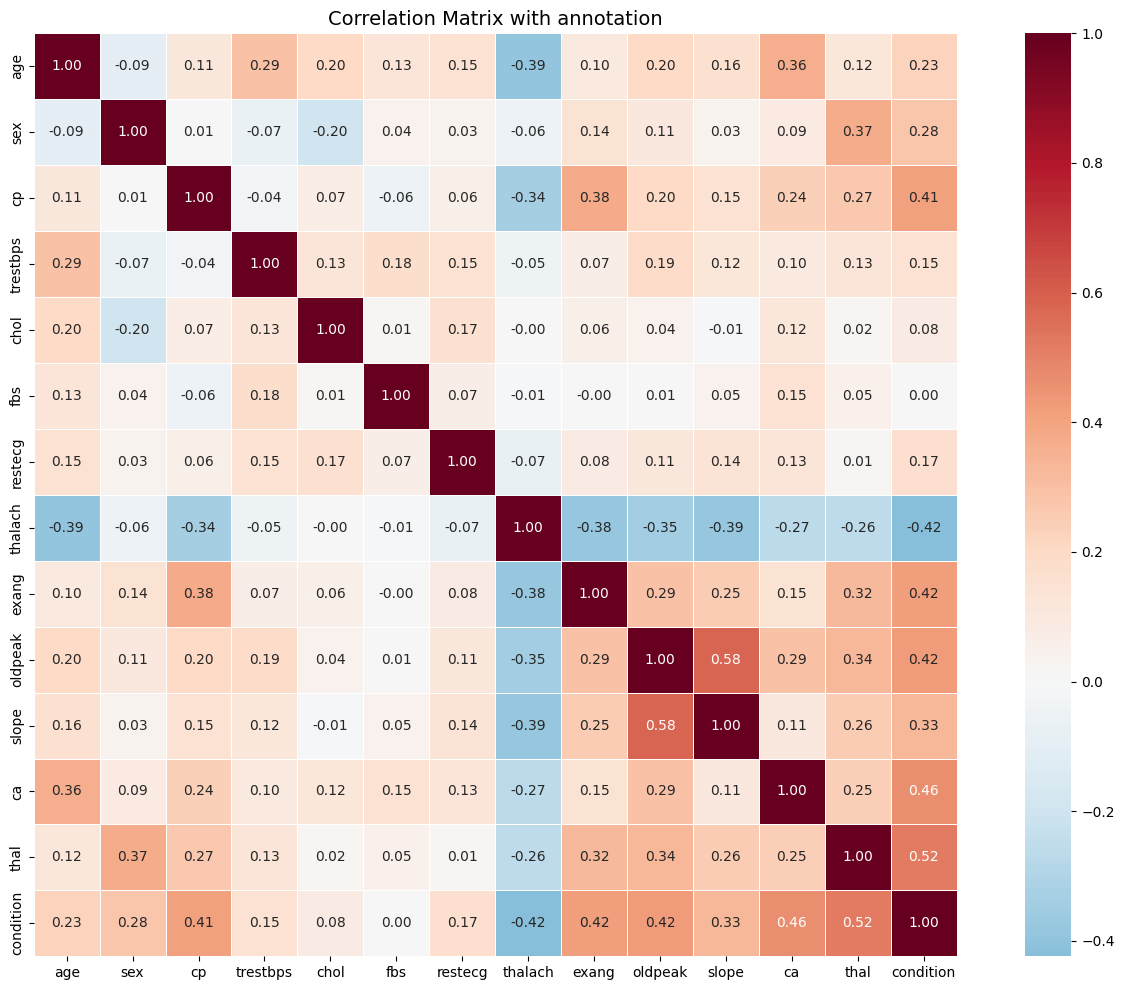

In [32]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=0.5, square=True)
plt.title('Correlation Matrix with annotation', fontsize=14)
plt.tight_layout()
plt.show()

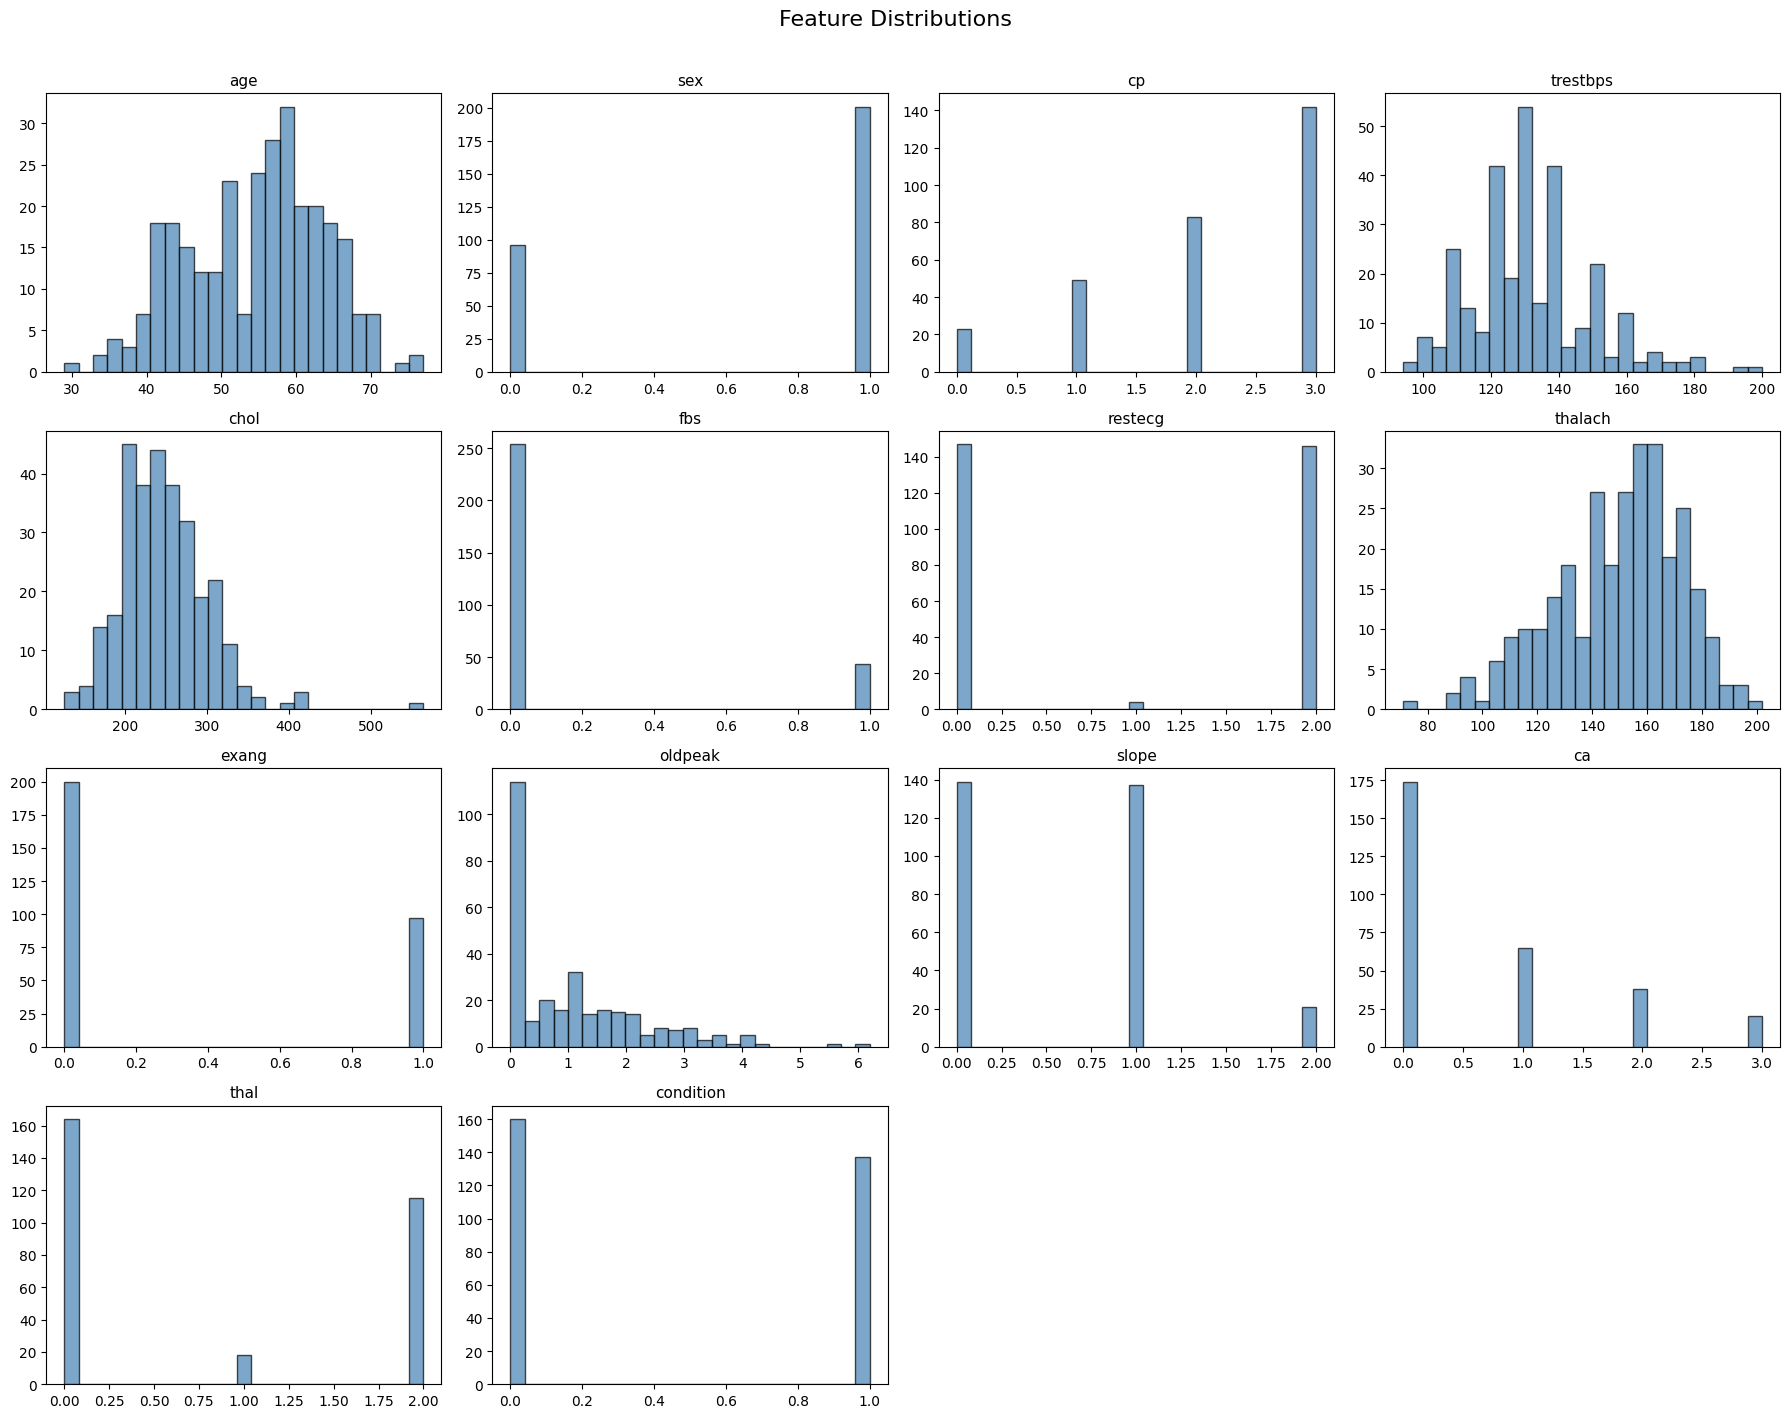

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(18, 14))
axes = axes.ravel()
for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(col, fontsize=11)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.suptitle('Feature Distributions', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

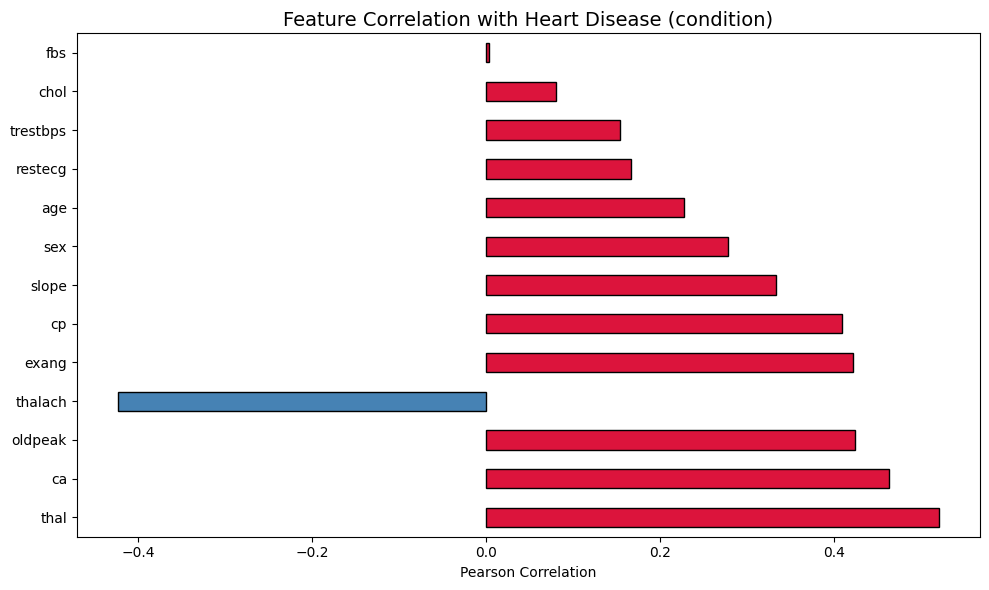


Top indicators of heart disease:
thal        0.520516
ca          0.463189
oldpeak     0.424052
thalach    -0.423817
exang       0.421355
cp          0.408945
slope       0.333049
sex         0.278467
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fbs         0.003167
Name: condition, dtype: float64


In [38]:
target_corr = df.corr()['condition'].drop('condition').sort_values(key=abs, ascending=False)
plt.figure(figsize=(10, 6))
colors = ['crimson' if v > 0 else 'steelblue' for v in target_corr.values]
target_corr.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Feature Correlation with Heart Disease (condition)', fontsize=14)
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.show()
print("\nTop indicators of heart disease:")
print(target_corr)

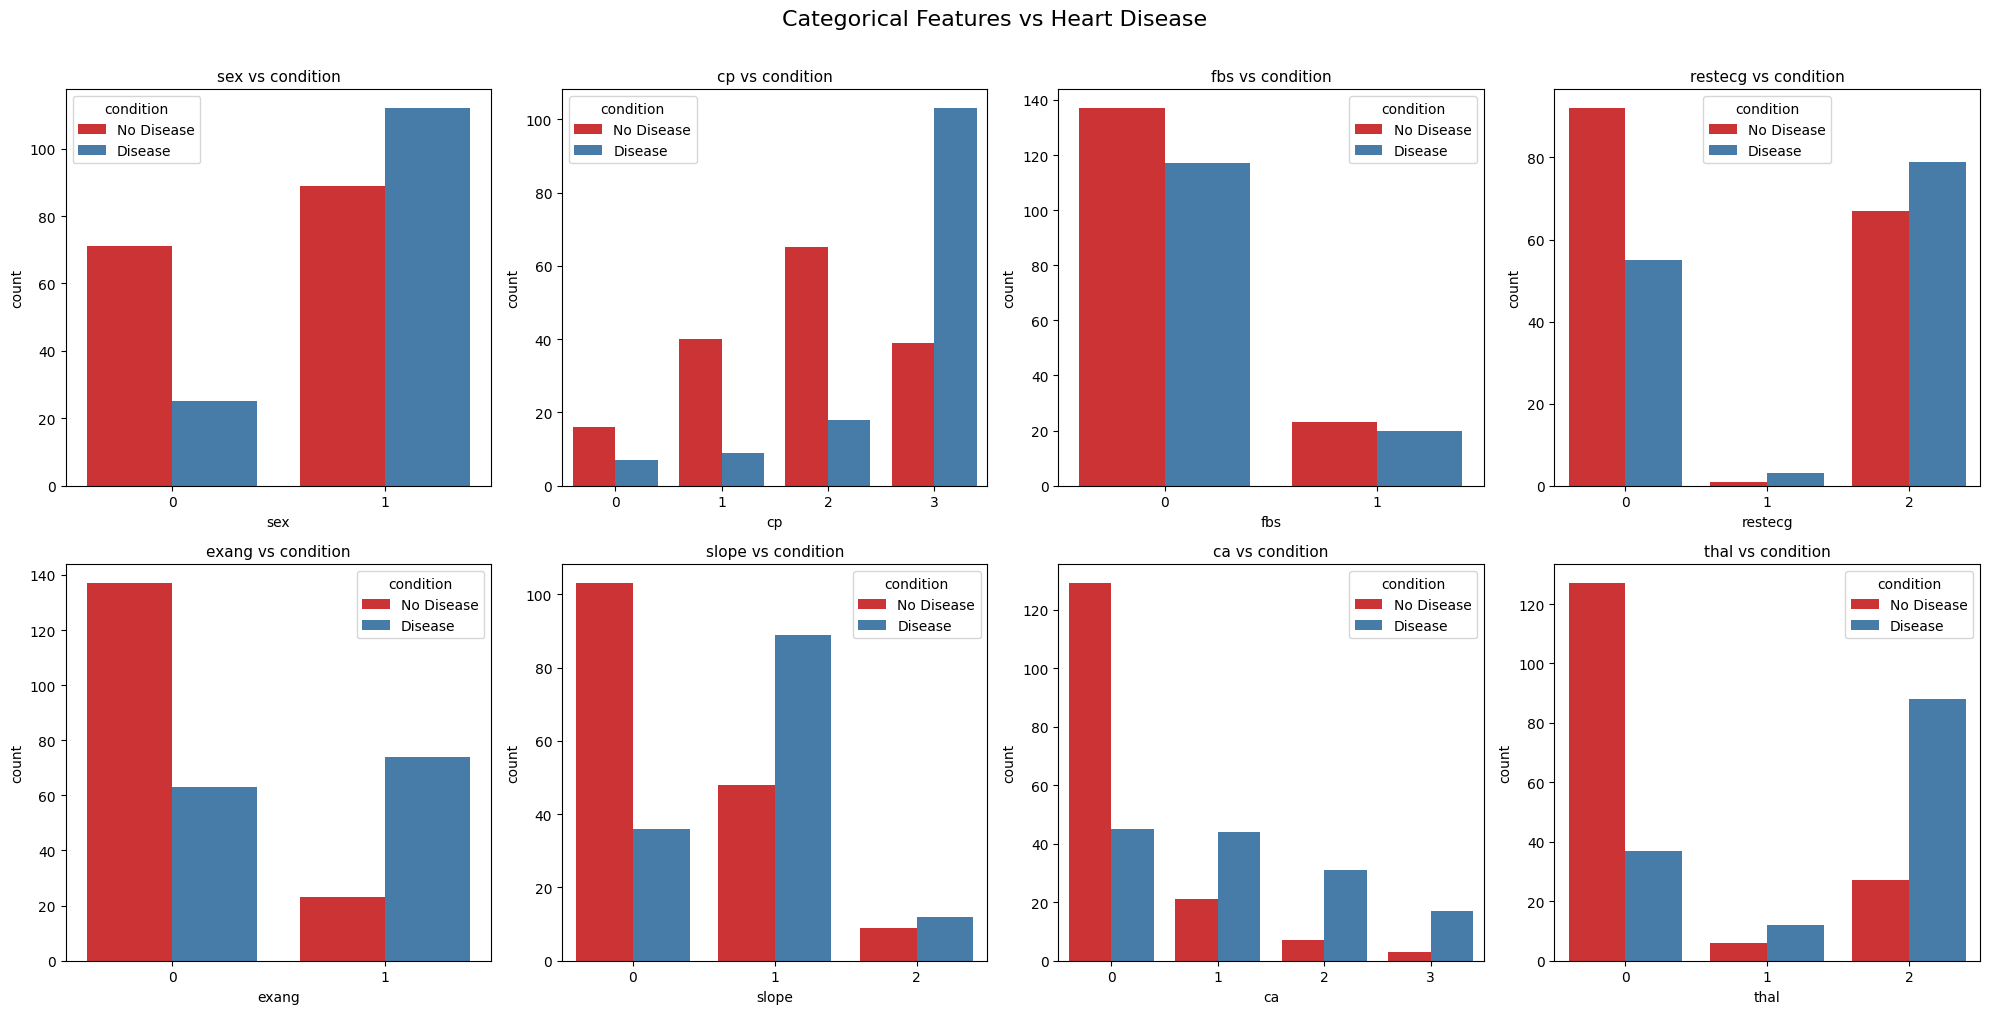

In [ ]:
categorical_feats = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()
for i, col in enumerate(categorical_feats):
    sns.countplot(data=df, x=col, hue='condition', ax=axes[i], palette='Set1')
    axes[i].set_title(f'{col} vs condition', fontsize=11)
    axes[i].legend(title='condition', labels=['No Disease', 'Disease'])
plt.suptitle('Categorical Features vs Heart Disease', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

C:\Users\redmi\AppData\Local\Temp\ipykernel_12056\79408176.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='condition', y=col, ax=axes[i], palette='Set2')
C:\Users\redmi\AppData\Local\Temp\ipykernel_12056\79408176.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Disease', 'Disease'])
C:\Users\redmi\AppData\Local\Temp\ipykernel_12056\79408176.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='condition', y=col, ax=axes[i], palette='Set2')
C:\Users\redmi\AppData\Local\Temp\ipykernel_12056\79408176.py:7: UserWarning: set_ticklabels() should only be us

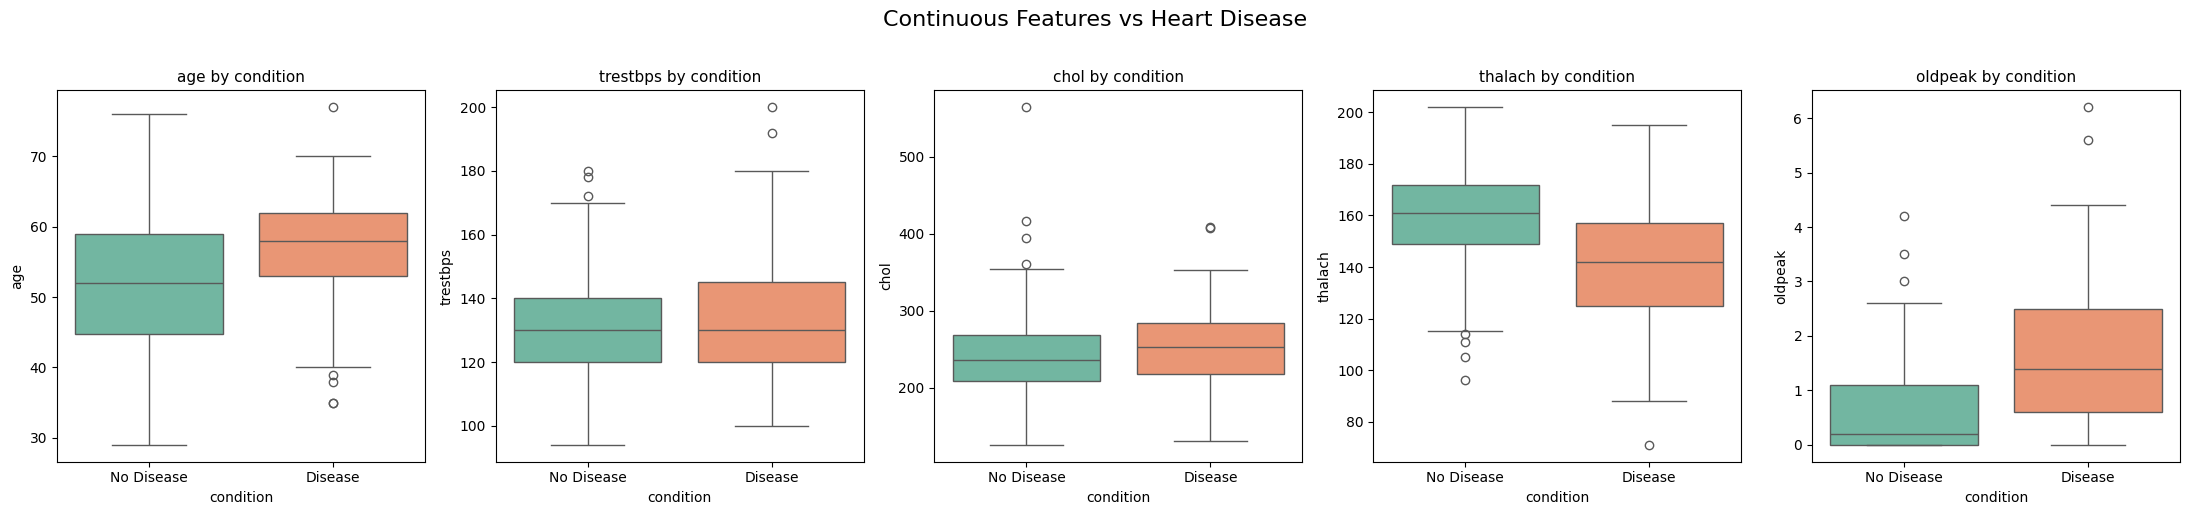

In [ ]:
continuous_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
fig, axes = plt.subplots(1, 5, figsize=(22, 5))
for i, col in enumerate(continuous_feats):
    sns.boxplot(data=df, x='condition', y=col, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} by condition', fontsize=11)
    axes[i].set_xticklabels(['No Disease', 'Disease'])
plt.suptitle('Continuous Features vs Heart Disease', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Feature Engineering

In [43]:
# Encode categorical variables (I am using one-hot encoding) 
df_eng = df.copy()

nominal_cols = ['cp', 'restecg', 'slope', 'thal']
df_eng = pd.get_dummies(df_eng, columns=nominal_cols, drop_first=True, dtype=int)

print(f"Shape after one-hot encoding: {df_eng.shape}")
df_eng.head()

Shape after one-hot encoding: (297, 19)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,condition,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,thal_1,thal_2
0,69,1,160,234,1,131,0,0.1,1,0,0,0,0,0,1,1,0,0,0
1,69,0,140,239,0,151,0,1.8,2,0,0,0,0,0,0,0,0,0,0
2,66,0,150,226,0,114,0,2.6,0,0,0,0,0,0,0,0,1,0,0
3,65,1,138,282,1,174,0,1.4,1,1,0,0,0,0,1,1,0,0,0
4,64,1,110,211,0,144,1,1.8,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
# Try to find outlier and handling it outliers using IQR capping (winsorization)
continuous_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def cap_outliers(series, factor=1.5):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - factor * IQR, Q3 + factor * IQR
    return series.clip(lower, upper)

outlier_counts = {}
for col in continuous_feats:
    before = ((df_eng[col] < df_eng[col].quantile(0.25) - 1.5 * (df_eng[col].quantile(0.75) - df_eng[col].quantile(0.25))) |
              (df_eng[col] > df_eng[col].quantile(0.75) + 1.5 * (df_eng[col].quantile(0.75) - df_eng[col].quantile(0.25)))).sum()
    outlier_counts[col] = before
    df_eng[col] = cap_outliers(df_eng[col])

print("Outliers detected & capped per feature:")
for col, cnt in outlier_counts.items():
    print(f"  {col}: {cnt} outliers capped")

Outliers detected & capped per feature:
  age: 0 outliers capped
  trestbps: 9 outliers capped
  chol: 5 outliers capped
  thalach: 1 outliers capped
  oldpeak: 5 outliers capped


In [ ]:

df_eng['age_x_oldpeak'] = df_eng['age'] * df_eng['oldpeak']       # older patients with ST depression
df_eng['thalach_x_exang'] = df_eng['thalach'] * df_eng['exang']   # max HR during exercise angina
df_eng['trestbps_x_chol'] = df_eng['trestbps'] * df_eng['chol']   # blood pressure × cholesterol risk
df_eng['age_x_thalach'] = df_eng['age'] * df_eng['thalach']       # age-adjusted max heart rate

print(f"Shape after interaction features: {df_eng.shape}")
print("New features:", ['age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach'])

Shape after interaction features: (297, 23)
New features: ['age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach']


In [40]:
# Scale / normalize numerical features ---
X = df_eng.drop('condition', axis=1)
y = df_eng['condition']

# Identifying the  numerical columns to scale
num_cols_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                     'age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach']

scaler = StandardScaler()
X[num_cols_to_scale] = scaler.fit_transform(X[num_cols_to_scale])

print("Numerical columns scaled (StandardScaler):", num_cols_to_scale)
print(f"\nFinal feature matrix shape: {X.shape}")
X.head()

KeyError: "['age_x_oldpeak', 'thalach_x_exang', 'trestbps_x_chol', 'age_x_thalach'] not in index"

In [41]:
# Data set summary after EDA and analysis
print("SUMMARY")
print(f"Original shape of Dataset:    {df.shape}")
print(f"After preprocessing and EDA shape:  X={X.shape}, y={y.shape}")
print(f"\nCategorical encoding: One-hot on {['cp', 'restecg', 'slope', 'thal']}")
print(f"Outlier handling:    IQR capping on {continuous_feats}")
print(f"Interaction features: age×oldpeak, thalach×exang, trestbps×chol, age×thalach")
print(f"Scaling:             StandardScaler on {len(num_cols_to_scale)} numerical columns")
print(f"\nTarget distribution:")
print(y.value_counts().rename({0: 'No Disease', 1: 'Disease'}))

SUMMARY
Original shape of Dataset:    (297, 14)
After preprocessing and EDA shape:  X=(297, 18), y=(297,)

Categorical encoding: One-hot on ['cp', 'restecg', 'slope', 'thal']
Outlier handling:    IQR capping on ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Interaction features: age×oldpeak, thalach×exang, trestbps×chol, age×thalach
Scaling:             StandardScaler on 9 numerical columns

Target distribution:
condition
No Disease    160
Disease       137
Name: count, dtype: int64
